Import libraries

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile, execute, BasicAer
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer import Aer
from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.visualization import plot_histogram
pi = math.pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
import re

Calculation of variational ground state energies $E_1$, $E_2$ and $E_3$

Lowest trial energy for N=1:  -0.4366 MeV
Lowest trial energy for N=2:  -1.7485 MeV
Lowest trial energy for N=3:  -2.0444 MeV


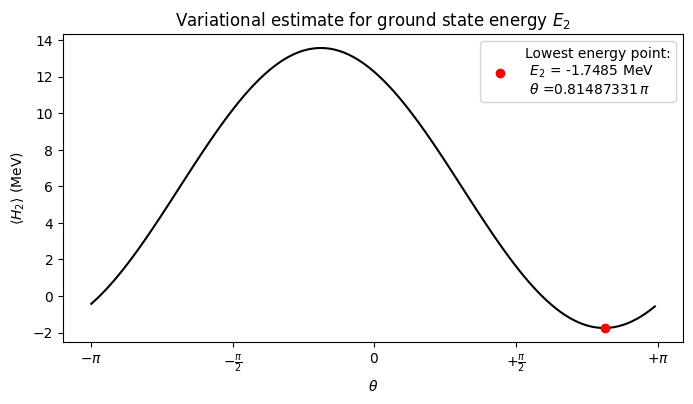

In [2]:
# Define deuterion Hamiltonian in the computational basis
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * Z^I) - (6.125 * I^Z) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * Z^I^I) - (6.125 * I^Z^I) - (2.143304 * X^X^I) - (2.143304 * Y^Y^I) +\
            + 9.625*(I^I^I) -9.625*(I^I^Z) - 3.913119*(I^X^X)  - 3.913119*(I^Y^Y)

# Deuteron parameters
m_p = 938.2720813 # MeV / c^2
m_n = 939.5654252 # MeV / c^2
mu = (m_p*m_n)/(m_p + m_n) # MeV / c^2
hbar_c = 197.326980 # Mev fm

# The ground state for H_1 is obtained as <1|H_1|1>, no need to use variational method
state = Statevector.from_int(1,2)
E_1 =  state.expectation_value(Hamilt_1).real 

# Loop over variational parameter theta for calculation of <H_2>
theta = np.arange(-3.14,+3.14,0.05)
eta =  np.arange(-3.14,+3.14,0.05)
exp_val_2 = np.empty(len(theta))
exp_val_3 = np.empty((len(theta),len(eta)))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    circuit2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    circuit2.x(0)

    # Rotation around y axis on qubit 1
    circuit2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    circuit2.cx(1,0)

    # Initialize state
    state2= Statevector.from_int(0, 4)

    # Evolve the state by the quantum circuit
    state2 = state2.evolve(circuit2)

    # Calculate expectation value
    exp_val_2[kk]=state2.expectation_value(Hamilt_2).real

    # loop over variational parameter eta for <H_3>
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        circuit3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        circuit3.x(0)

        # Rotation around y axis on qubit 1
        circuit3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        circuit3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        circuit3.cx(2,0)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Rotation around y axis on qubit 1
        circuit3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Add CNOT, control q1, target q0
        circuit3.cx(1,0)

        # Initialize state
        state3= Statevector.from_int(0, 8)

        # Evolve the state by the quantum circuit
        state3 = state3.evolve(circuit3)

        # Calculate expectation value
        exp_val_3[kk, jj]=state3.expectation_value(Hamilt_3).real


# Lowest trial energy for <H_2> and <H_3>
E_2 = exp_val_2.min()
E_3 = exp_val_3.min()

# Plot of energy as a function of theta
# Plot style options
w = 8
h = 4
fontsize = 12
cmap = plt.get_cmap('tab20')
# <H_2>(theta)
lbl = 'Lowest energy point:\n $E_2$ = ' + str(round(E_2,4)) + ' MeV\n $\\theta$ =' + str(theta[np.where(exp_val_2 == E_2)]/pi).replace('[', '').replace(
    ']', '') + '$\,\\pi$'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.plot(theta, exp_val_2, 'k')
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
plt.scatter(theta[np.where(exp_val_2 == E_2)], E_2, zorder= 5, color='red', label = lbl )
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.title('Variational estimate for ground state energy $E_2$')
# Results
print('Lowest trial energy for N=1: ', round(E_1, 4), 'MeV')
print('Lowest trial energy for N=2: ', round(E_2, 4), 'MeV')
print('Lowest trial energy for N=3: ', round(E_3, 4), 'MeV')

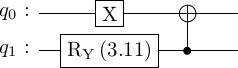

In [3]:
# Draw the circuit for N=2
circuit2.draw('latex')

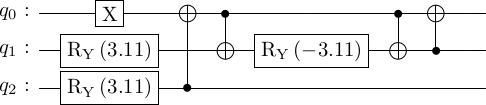

In [4]:
# Draw the circuit for N=3
circuit3.draw('latex')

Fit for $E_N$ using Lüscher formula

Fit parameters [k gamma]= [ 0.2302075513837736 -1.8109493128993897 ]
Infinite-basis extrapolated binding energy using h^2 k^2 / 2m:  -2.1978 MeV ( 1.0 % off)


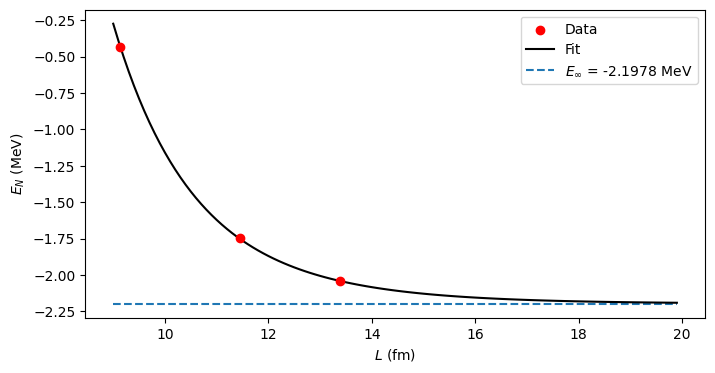

In [5]:
# List of trial energies
E_data = np.array([E_1, E_2, E_3])

# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -(hbar_c*hbar_c*k*k/(2*mu))*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/mu

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data)

# Fit plot
E_exact = -2.22 #MeV
ll = np.arange(9,20,0.1)
lbl = '$E_\infty$ = ' + str(round(-hbar_c*hbar_c*k*k/(2*mu),4)) + ' MeV'
lbl2 = '$E_{exact}$= '+ str(E_exact)+' MeV'
plt.figure(figsize=(w,h))
plt.scatter(L, E_data, color = 'red', zorder=5, label = 'Data')
plt.plot(ll, luscher(ll, k, gamma), 'k', zorder= 4, label= 'Fit')
plt.plot(ll, -hbar_c*hbar_c*k*k/(2*mu)*np.ones(len(ll)), '--', zorder = 3, label = lbl)
plt.legend()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E_N$ (MeV)')

# Results
E_gs_0 = -hbar_c*hbar_c*k*k/(2*mu)
print('Fit parameters [k gamma]= [', k, gamma, ']')
print('Infinite-basis extrapolated binding energy using h^2 k^2 / 2m: ', round(E_gs_0,4), 'MeV (', round(np.abs(100*(E_exact -E_gs_0)/E_exact),1),'% off)' )

First test of $N=2$ simulation

Text(0.5, 1.0, 'Variational estimate for ground state energy $E_2$')

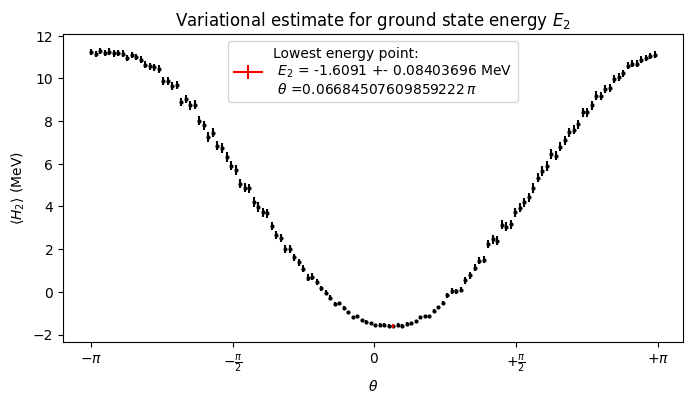

In [6]:
# Function that assigns 0 value to undefined keys in the counts dictionary
def check_counts_2(dic):
    if '11' not in dic:
        dic['11'] = 0
    if '10' not in dic:
        dic['10'] = 0
    if '01' not in dic:
        dic['01'] = 0
    if '00' not in dic:
        dic['00'] = 0


# Simulator setup
Aer.backends()

Hamilt_2 = (5.906709 * I^I) + (0.218291 * Z^I) - (6.125 * I^Z) - (2.143304 * X^X) - (2.143304 * Y^Y)

# Measurement circuit ZZ
qc_meas_ZZ = QuantumCircuit(2)
qc_meas_ZZ.measure_all()
# Measurement circuit YY
qc_meas_YY = QuantumCircuit(2)
qc_meas_YY.sdg(0)
qc_meas_YY.h(0)
qc_meas_YY.sdg(1)
qc_meas_YY.h(1)
qc_meas_YY.measure_all()
# Measurement circuit XX
qc_meas_XX = QuantumCircuit(2)
qc_meas_XX.h(0)
qc_meas_XX.h(1)
qc_meas_XX.measure_all()
#Measurement circuit Bell states
qc_meas_Bell = QuantumCircuit(2)
qc_meas_Bell.cx(0,1)
qc_meas_Bell.h(0)
qc_meas_Bell.measure_all()


# Number of runs per simulation
shots = 1000

theta = np.arange(-3.14,+3.14,0.05)
exp_val_2 = np.empty(len(theta))
dexp_val_2 = np.empty(len(theta))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    qc2.x(0)

    # Rotation around y axis on qubit 1
    qc2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    qc2.cx(1,0)

    # Add measurement circuit
    qc2_ZZ = qc2.compose(qc_meas_ZZ)
    #qc2_YY = qc2.compose(qc_meas_YY)
    #qc2_XX = qc2.compose(qc_meas_XX)
    qc2_Bell = qc2.compose(qc_meas_Bell)

    # Transpile for simulator
    simulator = Aer.get_backend('qasm_simulator')
    comp_qc2_ZZ = transpile(qc2_ZZ, simulator)
    #comp_qc2_YY = transpile(qc2_YY, simulator)
    #comp_qc2_XX = transpile(qc2_XX, simulator)
    comp_qc2_Bell = transpile(qc2_Bell, simulator)
    # Run and get counts
    result_ZZ = simulator.run(comp_qc2_ZZ, shots = shots).result()
    #result_YY = simulator.run(comp_qc2_YY, shots = shots).result()
    #result_XX = simulator.run(comp_qc2_XX, shots = shots).result()
    result_Bell = simulator.run(comp_qc2_Bell, shots = shots).result()

    counts_ZZ = result_ZZ.get_counts(comp_qc2_ZZ)
    #counts_YY = result_YY.get_counts(comp_qc2_YY)
    #counts_XX = result_XX.get_counts(comp_qc2_XX)
    counts_Bell = result_Bell.get_counts(comp_qc2_Bell)

    # Check keys
    check_counts_2(counts_ZZ)
    #check_counts_2(counts_YY)
    #check_counts_2(counts_XX)
    check_counts_2(counts_Bell)

    # Calculate expectation values
    exp_ZI = (counts_ZZ['10'] - counts_ZZ['01'])/shots
    exp_IZ =  (counts_ZZ['01'] - counts_ZZ['10'])/shots
    exp_XX_YY = counts_Bell['10']/shots
    exp_ZZ = (counts_ZZ['00'] + counts_ZZ['11'] - counts_ZZ['01'] - counts_ZZ['10'])/shots
    
    exp_val_2[kk] = 0.218291*exp_ZI - 6.125*exp_IZ + 5.906709 -2.143304*exp_XX_YY

    # Calculate std deviation as <H^2> -<H>^2
    var_counts = 5.906709**2 + 2*5.906709*0.218291*exp_ZI +\
                    (-2)*5.906709*6.125*exp_IZ -2*2.143304*5.906709*exp_XX_YY +\
                    0.218291**2 - 2*0.218291*6.125*exp_ZZ + 6.125**2 + 2*(2.143304**2) - exp_val_2[kk]*exp_val_2[kk]
    std_counts = np.sqrt(np.abs(var_counts))
    dexp_val_2[kk]= std_counts/np.sqrt(shots)
    #print(E_2, 'MeV')

# Lowest trial energy for <H_2>
E_2 = exp_val_2.min()
dE_2= dexp_val_2[np.where(exp_val_2 == E_2)]
# Plot of energy as a function of theta
# Plot style options
w = 8
h = 4
fontsize = 12
cmap = plt.get_cmap('tab20')
# <H_2>(theta)
lbl = 'Lowest energy point:\n $E_2$ = ' + str(round(E_2,4)) + ' +- ' + str(dE_2).replace('[', '').replace(
    ']', '')+ ' MeV\n $\\theta$ =' +\
    str(theta[np.where(exp_val_2 == E_2)][0]/pi).replace('[', '').replace(
    ']', '') + '$\,\\pi$'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.errorbar(theta, exp_val_2, yerr = dexp_val_2, color = 'black', fmt="o", ms=2)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
plt.errorbar(theta[np.where(exp_val_2 == E_2)][0], E_2, dexp_val_2[np.where(exp_val_2 == E_2)][0], zorder= 5, color='red', label = lbl)
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.title('Variational estimate for ground state energy $E_2$')
